# Creating a new Machine Scoring Method
Hello!  This in Matt's quick tutorial on how to create and implement a new direct scoring method and then testing it on a target.

## Step 1: Load nessecary modules

In [1]:
# Add python modules
import numpy as np
import cv2
import matplotlib.pyplot as plt
from copy import deepcopy

# Add parent directory for custom modules
from sys import path as sysPath
sysPath.append('../')
sysPath.append('../Machine_Score/')

# Load custom modules that simr has loaded
import main_SIMR as simr
gm = simr.gm
im = simr.im
ic = simr.ic
ms = simr.ms
sa = simr.sa
dc = simr.ms.dc
mc = simr.ms.mc
fc = simr.ms.fc

simr.test()
gm.test()
im.test()
ic.test()
ms.test()
dc.test()
mc.test()
sa.test()

SIMR: Hi!  You're in Matthew's main program for all things galaxy collisions
GM: Hi!  You're in Matthew's module for generally useful functions and classes
IM: Hi!  You're in Matthew Ogden's information module for SPAM
IC: Hi!  You're in Matthew's main code for all things image creation.
MS: Hi!  You're in Matthew's SIMR module for all things machine scoring images
DC: Hi!  You're in direct_image_compare.py
MC: Hi!  You're in masked_image_compare.py
SA: Hi!  You're in Matthew's Main program for score analysis!


___
## Step 2: Load Target and single Run Info class
Needed for loading the target image and running through models later.

In [2]:
tDir = '../targetDir1'
tDir = gm.validPath(tDir)

tInfo = im.target_info_class( targetDir = tDir, printAll=False)
if tInfo.status == False:
    print("WARNING: target info class bad")
else:
    print("Target Good!")

# Get run info class
rInfo = tInfo.getRunInfo( rID='r00000' )

if rInfo.status == False:
    print("WARNING")
else:
    print("Run '%s' Good!"%rInfo.get('run_id'))

Target Good!
Run 'r00000' Good!


---
## Step 4: Load score parameter file
For loading in the the new score parameter file.  You can edit this file as you see fit

In [25]:
tParams = tInfo.getImageParams()
#gm.pprint(tParams)

# Create a new score param in tInfo if needed
new_name = 'new_score'
new_params = {}

# Copy desired starting parameter.
new_params[new_name] = deepcopy( tParams['zoo_2'] )
new_params[new_name]['name'] = new_name
new_params[new_name]['cmpArg']['direct_compare_function'] = 'correlation'
new_params[new_name]['cmpArg']['feature_function'] = 'hog'
new_params[new_name]['cmpArg']['kernal_size'] = 7
new_params[new_name]['cmpArg']['non_zero_pixels'] = False
new_params[new_name]['cmpArg']['type'] = 'feature_compare'
gm.pprint(new_params)

#tInfo.addImageParams(new_params, overWrite = True)


{'new_score': {'cmpArg': {'direct_compare_function': 'correlation',
                          'feature_function': 'hog',
                          'function_name': 'correlation',
                          'kernal_size': 7,
                          'non_zero_pixels': False,
                          'targetName': 'zoo_2',
                          'targetType': 'target_image',
                          'type': 'feature_compare'},
               'imgArg': {'blur': {'size': 5,
                                   'type': 'gaussian_blur',
                                   'weight': 0.75},
                          'comment': 'Smaller '
                                     'Image '
                                     'by '
                                     'Matthew.',
                          'galaxy_centers': {'px': 50,
                                             'py': 50,
                                             'sx': 100,
                                             'sy': 50},


___
## Step 5: Load image for comparison
Load in the target image and a model image for initial comparison

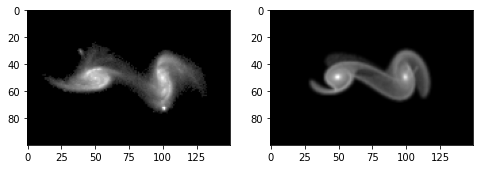

In [26]:
mImg = rInfo.getModelImage( new_params['new_score']['imgArg']['name'] )
tImg = tInfo.getTargetImage( new_params['new_score']['cmpArg']['targetName'] )

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(tImg, cmap='gray')
plt.subplot(122)
plt.imshow(mImg, cmap='gray')

Model:  0.27099064
Unperturbed:  0.29762793


0.6146088992391223

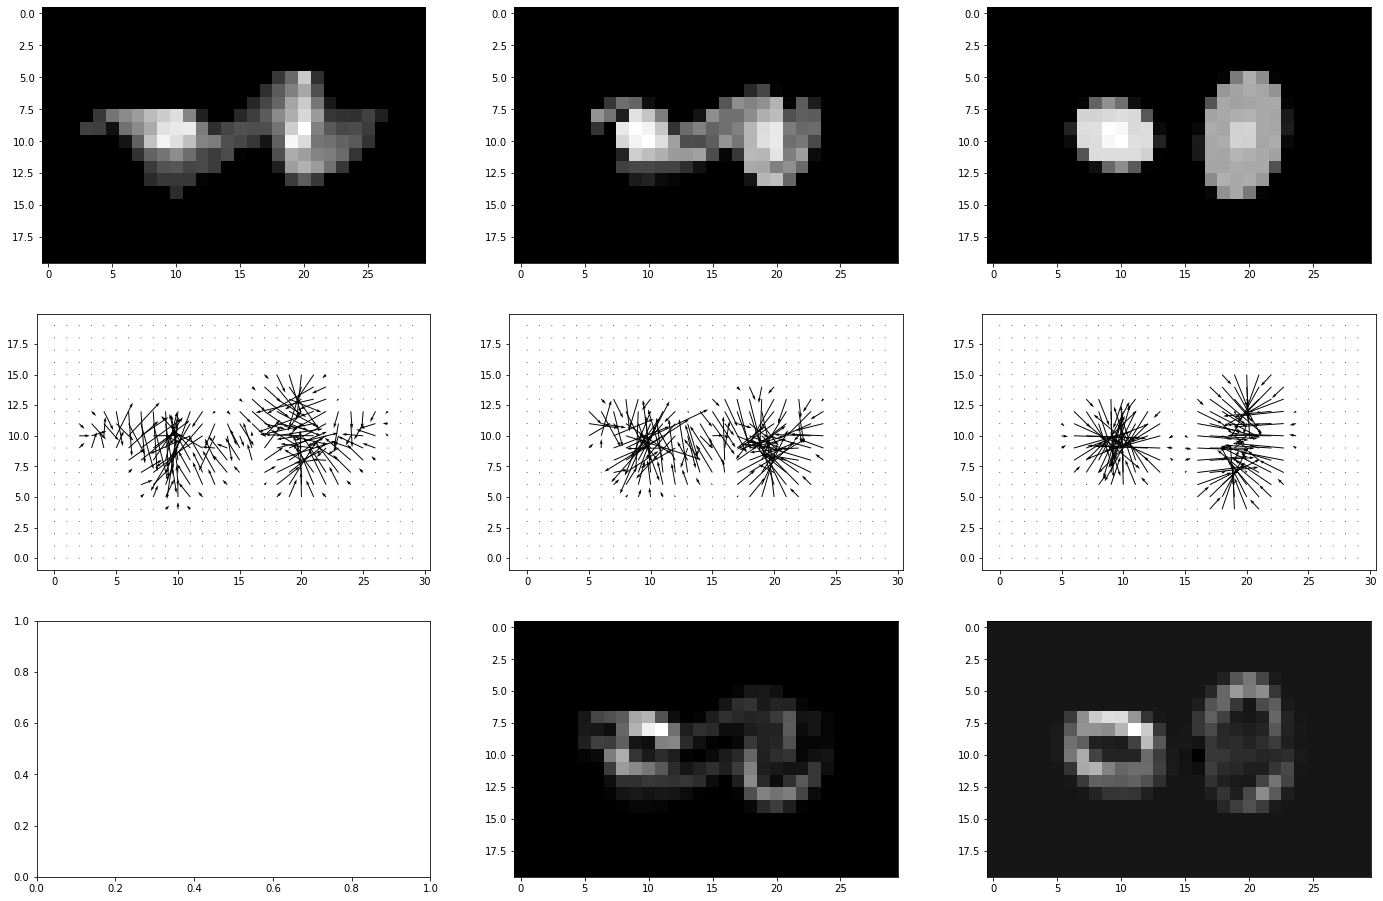

In [58]:

def score_hog_dot( img1, img2, img3, cmpArg ):
    
    img1 = cv2.resize( img1, (30,20) )    
    img2 = cv2.resize( img2, (30,20) )   
    img3 = cv2.resize( img3, (30,20) )
    
    fig, ax = plt.subplots( 3, 3, figsize=(24,16) )
    
    ax[0,0].imshow( img1[::-1,:], cmap='gray' )
    ax[0,1].imshow( img2[::-1,:], cmap='gray' )
    ax[0,2].imshow( img3[::-1,:], cmap='gray' )
    
    cmpArg['kernal_size'] = 3
    
    # Get HOG features, (Magnitude of change and Angle of change)
    mag1, ang1 = fc.extract_hog( img1, cmpArg )
    mag2, ang2 = fc.extract_hog( img2, cmpArg )
    mag3, ang3 = fc.extract_hog( img3, cmpArg ) 
    
    v1 = np.zeros(( mag1.shape[0], mag1.shape[1], 2 ) )
    v1[:,:,0] = mag1 * np.cos( ang1 )
    v1[:,:,1] = mag1 * np.sin( ang1 )
    
    v2 = np.zeros(( mag2.shape[0], mag2.shape[1], 2 ) )
    v2[:,:,0] = mag2 * np.cos( ang2 )
    v2[:,:,1] = mag2 * np.sin( ang2 )

    v3 = np.zeros(( mag3.shape[0], mag3.shape[1], 2 ) )
    v3[:,:,0] = mag3 * np.cos( ang3 )
    v3[:,:,1] = mag3 * np.sin( ang3 )
    
    ax[1,0].quiver( v1[:,:,0], v1[:,:,1] )
    ax[1,1].quiver( v2[:,:,0], v2[:,:,1] )
    ax[1,2].quiver( v3[:,:,0], v3[:,:,1] )
        
    
    sImg1 = np.zeros_like(mag1)
    sImg2 = np.zeros_like(mag1)
    
    for i in range( mag1.shape[0] ):
        for j in range( mag1.shape[1] ):
            sImg1[i,j] = np.dot( v1[i,j,:], v2[i,j,:] )
            sImg2[i,j] = np.dot( v1[i,j,:], v3[i,j,:] )
    

    ax[2,1].imshow( sImg1[::-1,:], cmap='gray' )
    ax[2,2].imshow( sImg2[::-1,:], cmap='gray' )
    
    print( 'Model: ', np.average( sImg1 ) )
    print( 'Unperturbed: ', np.average( sImg2 ) )
    
    return score

        
iImg = rInfo.getModelImage( 'zoo_2', initImg=True)
score_hog_dot( tImg, mImg, iImg, new_params[new_name]['cmpArg'])

___
## Step 6: Create the new comparison function!
Note: All direct image comparison take 3 arguments
- 2x images of the same size
- dict of comparison arguments

In [28]:
# Image HOG Comparison.  Code copied and modified from the following link:
# https://learnopencv.com/histogram-of-oriented-gradients/

def score_hog( img1, img2, cmpArg ):
    
    # Get HOG features, (Magnitude of change and Angle of change)
    mag1, ang1 = fc.extract_hog( img1, cmpArg )
    mag2, ang2 = fc.extract_hog( img2, cmpArg ) 
    
    # Normalize magnitude to between 0 and 1.
    maxMag = np.amax( [ np.amax(mag1), np.amax(mag2) ] )
    mag1 /= maxMag
    mag2 /= maxMag
    
    # Normalize angle between 0 and 1, and allow periodic comparison
    print( np.amax(ang1), np.amin(ang1) )
    print( np.amax(ang2), np.amin(ang2) )
    
    # Find minimum angle difference since it's periodic
    diffAr = np.zeros( (ang1.shape[0], ang1.shape[1], 3) )
    diffAr[:,:,0] = np.abs( ang1 - ang2 )
    diffAr[:,:,1] = np.abs( ang1 - ang2 + np.pi )
    diffAr[:,:,2] = np.abs( ang1 - ang2 - np.pi )
    
    dAng = np.amin(diffAr,axis=2)
    
    # Normalize between 0 and 1, max angle difference is pi

    if cmpArg.get('non_zero_pixels',False):

        eMag = mc.non_zero_mask( mag1, mag2 )
        eAng = mc.non_zero_mask( ang1, ang2 )
        eIndex = mc.non_zero_mask( eMag, eAng )

        mag1 = mc.extractBinaryMask( mag1, eIndex )
        mag2 = mc.extractBinaryMask( mag2, eIndex )

        ang1 = mc.extractBinaryMask( ang1, eIndex )
        ang2 = mc.extractBinaryMask( ang2, eIndex )
    
    cmp_func = cmpArg.get('direct_compare_function','absolute_difference')
    
    if cmp_func == 'absolute_difference':        

        dMag = np.abs( mag1 - mag2 )
        s1 = np.sum( dMag ) / dMag.size
        s1 = 1 - s1
        
        s2 = np.sum( dAng ) / dAng.size
        s2 = 1 - s2
    
    elif cmp_func == 'absolute_difference_squared':

        dMag = np.abs( mag1 - mag2 )
        dMag = np.power( dMag, 2 )
        s1 = np.sum( dMag ) / dMag.size
        s1 = 1 - s1
        
        dAng = np.power( dAng, 2 )
        s2 = np.sum( dAng ) / dAng.size
        s2 = 1 - s2
        
    else:
        print("FC: Compare function '%s' not available for hog"%cmp_func)
        return None


    w1 = cmpArg.get('weight_mag',0.5)
    w2 = cmpArg.get('weight_ang',0.5)
    score = s1*w1 + s2*w2
    
    return score


# Create a new score param in tInfo if needed
new_name = 'new_score'
new_params = {}

# Copy desired starting parameter.
new_params[new_name] = deepcopy( tParams['zoo_2'] )
new_params[new_name]['name'] = new_name
new_params[new_name]['cmpArg']['direct_compare_function'] = 'absolute_difference_squared'
new_params[new_name]['cmpArg']['feature_function'] = 'hog'
new_params[new_name]['cmpArg']['kernal_size'] = 7
new_params[new_name]['cmpArg']['weight_mag'] = 0
new_params[new_name]['cmpArg']['weight_ang'] = 1
new_params[new_name]['cmpArg']['non_zero_pixels'] = True
new_params[new_name]['cmpArg']['type'] = 'feature_compare'
#gm.pprint(new_params)

gm.saveJson( new_params, '../param/hog.json')

score = score_hog( tImg, mImg, new_params[new_name]['cmpArg'] )
print(score)

6.275563 0.0
6.281614 0.0
0.6146088992391223


___
## Step 7: Load new function into direct image module
This will allow the existing code to run the function in a standard new score operation.

In [29]:
'''
# Assign new function to test function in direct image compare
dc.set_test_compare(score_ssim)

# Check if all modules loaded the same function
print("NOTE! All should match")
print('nb:   ',score_ssim)
print('dc:   ',dc.test_compare)
print('ms:   ',ms.dc.test_compare)
print('simr: ',simr.ms.dc.test_compare)
'''

'\n# Assign new function to test function in direct image compare\ndc.set_test_compare(score_ssim)\n\n# Check if all modules loaded the same function\nprint("NOTE! All should match")\nprint(\'nb:   \',score_ssim)\nprint(\'dc:   \',dc.test_compare)\nprint(\'ms:   \',ms.dc.test_compare)\nprint(\'simr: \',simr.ms.dc.test_compare)\n'

___
## Step 8: Execute new score operation for a single model.
This confirms that the score function operates correcting in the new score pipeline

In [30]:
newRunArg = gm.inArgClass()
newRunArg.setArg( 'newInfo', True )
rInfo = tInfo.getRunInfo( rID='r00000', rArg=newRunArg )

newScoreArg = gm.inArgClass()
newScoreArg.setArg( 'rInfo', rInfo )
newScoreArg.setArg( 'scoreParams', new_params )
newScoreArg.setArg( 'printAll', True )
newScoreArg.setArg( 'newScore', True )
newScoreArg.setArg( 'overWrite', True )
newScoreArg.setArg( 'newInfo', True )

simr.simr_run( rInfo = rInfo, arg = newScoreArg )
rInfo.printScores()

SIMR.pipelineRun: Inputs
	 - rDir: None
	 - rInfo: <class 'Support_Code.info_module.run_info_class'>
SIMR.pipelineRun: 
	 - rInfo:  <Support_Code.info_module.run_info_class object at 0x7f8a6bba23a0>
MS: Run:
MS: scoreName: new_score
MS: target_compare_setup: new_score
	 -  paramName: new_score
	 -  modelName: zoo_2
	 - targetName: zoo_2
	 - Read target image
	 - Read model image
MS: New Score!: new_score - 0.614609 - 0.614609
IM: run_info_class.printScores()
	 - run_id: r00000
	 - zoo_merger: 0.945946
	 - machine_scores: 1
	 - new_score: 0.614609


___
## Step 9: Execute new score operation for a complete target.
Execute the new function for a target and see if it works across many models

In [31]:
newTarget = gm.inArgClass()
newTarget.setArg( 'tInfo', tInfo )
newTarget.setArg( 'scoreParams', new_params )
newTarget.setArg( 'printAll', False )
newTarget.setArg( 'newScore', True )
newTarget.setArg( 'overWrite', True )
newTarget.setArg( 'newRunInfo', True )

simr.simr_target( arg=newTarget )

SIMR: pipelineTarget: input
	 - tDir: None
	 - tInfo: <class 'NoneType'>
SIMR: simr_target status:
	 - tInfo.status: True
SIMR: new_target_scores:
	 - tInfo: True
	 - Runs needing scores: 1293


***
## Step 10: View results!
View if your new method does well or not.

<AxesSubplot:title={'center':'new_score:\nCorr: -0.0879'}, xlabel='zoo_merger_score', ylabel='new_score'>

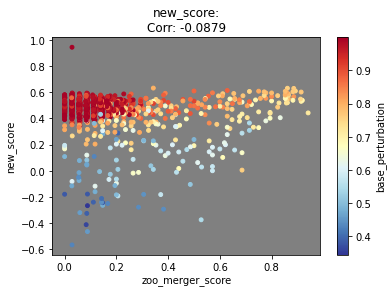

In [32]:
scores = tInfo.getScores()
sa.getNamedPlot(scores)

___
## Step 11: Add new function to direct_image_comparison.py

## Step 12: Rename parameter and save
- Create a new dict of the new score parameter
    - Parameter name
    - cmpMethod name: Match name of function in directory_image_compare
   

In [ ]:
param = deepcopy( new_params['new_score'] )
param['name'] = 'base0_ssim'
param['cmpArg']['cmpMethod'] = 'ssim'

gm.pprint(param)

___
## Step 13: Save in a score parameter file

In [ ]:
# Load existing score parameter file
pLoc = gm.validPath('../param/base0.json')
print(pLoc,'\n')
baseParamClass = im.group_score_parameter_class(pLoc = pLoc)

#gm.pprint(baseParams)

# Add new score parameter to dict
baseParamClass.group[ param['name'] ] = param
gm.pprint(baseParamClass.group)
baseParamClass.saveParam( saveLoc = '../param/base0.json' )


___
## Step 14: Have target run the score parameter file you just updated

In [ ]:
newTarget = gm.inArgClass()
newTarget.setArg( 'tInfo', tInfo )
newTarget.setArg( 'scoreParams', baseParamClass.group )
newTarget.setArg( 'printAll', False )
newTarget.setArg( 'newScore', True )
#newTarget.setArg( 'overWrite', True )

#gm.pprint(newTarget.get('scoreParams'))

simr.simr_target( arg=newTarget )

___
## Step 15: view target results of new score function! Again!

In [ ]:
scores = tInfo.getScores()
ax = sa.getNamedPlot(scores, sName = 'base0_ssim' )